# [약품식별 인공지능 개발을 위한 경구 약제 이미지 분류]
- 경구약제 약품식별 결과를 안내하고 피드백할 수 있는 AI 서비스 모델이 요구되며, 이를 위해 학습용 경구약제 이미지데이터 셋과 약품 정보를 분류하는 것이 필요

- 개발 내용
  - 이미지 데이터 전처리 및 데이터 확인
  - 이미지 처리 기술을 활용하여 경구 약제 이미지 분류
- 필요 기술 스택
  - Python, Pillow or Opencv, Deep learning
  - Git
- Dataset
  - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576







[추가 내용]
- 단일 선택 시, 데이터가 커져 전처리가 힘들지만, 모델링은 수월
- 조합 선택 시, 전처리는 쉽지만, 그만큼 모델링에서 특화된 부분으로 보여주어야 함

# 0. 데이터 전처리
- colab에서 실행 불가

In [ ]:
import json
import glob
import cv2
import os

dir_1 = glob.glob('Data/1.Training/labeling_data/drug/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')
# print(json_names[:3])

temp_img_dir = glob.glob('Data/1.Training/raw_data/drug/*')
# print(len(temp_img_dir))
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')

# print(img_names[:10])
i = 0
# os.mkdir('Data/1.Training/images/' + 'hi')
for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = 'Data/1.Training/images/' + file_name[:8]
        if not os.path.isdir(file_dir):
            os.mkdir(file_dir)

        file_dir = file_dir + '/' + file_name

        if not os.path.isfile(file_dir):
            # print(file_dir)
            x, y, w, h = js['annotations'][0]['bbox']

            cx = x + w // 2
            cy = y + h // 2
            w_h, h_h = max(w, h), max(w, h)  # 깨끗한 data 를 얻기 위해 크롭영역을 정방형으로 해준다. 기준은 둘 중 큰 값
            x = cx - (w_h // 2)
            y = cy - (h_h // 2)

            # print(x, y, w, h)
            img_names[idx] = img_names[idx].replace('\\', '/', 10)
            # print(img_names[idx])
            img = cv2.imread(img_names[idx], cv2.IMREAD_COLOR)
            cropped_img = img[y:y + h_h, x:x + w_h]
            cropped_img = cv2.resize(cropped_img, (64, 64))
            if idx % 100 == 0:
                print('진행상황: {} / {}'.format(idx, len(img_names)))
            cv2.imwrite(file_dir, cropped_img)
        else:
            print('이미 처리한 데이터 입니다.')
            continue

# 1. 구글 드라이브 마운드

In [ ]:
#google drive 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. 라이브러리 import

In [6]:
#import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import torch
import pandas
import seaborn as sns

import glob #파일명 다 긁어오기
import PIL
import cv2 #이미지 데이터 전처리, 이미지 불러오기

import imageio #이미지 불러오기
import skimage # Numpy배열로 이미지 객체를 다룬다.
import skimage.io
import skimage.transform

from sklearn.model_selection import train_test_split

# 3. csv 파일 읽어오기
- csv: 데이터 폴더 엑셀화한 문서

In [7]:
df = pd.read_csv('/content/drive/MyDrive/SWBootcamp_Personal/DataSet.csv')

In [8]:
df.sample(100).head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
5424,K-039108_0_0_1_0_90_120_200.png,.png,2021-10-06 14:28,2021-10-06 14:28,2021-10-06 14:28,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
1953,K-038927_0_0_1_1_70_180_200.png,.png,2021-11-19 16:10,2021-11-19 16:10,2021-11-19 16:10,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
8717,K-039147_0_0_1_2_75_100_200.png,.png,2021-09-07 16:19,2021-09-07 16:19,2021-09-07 16:19,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
6446,K-039136_0_1_1_1_60_040_200.png,.png,2021-09-09 14:05,2021-09-09 14:05,2021-09-09 14:05,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9482,K-039147_0_2_1_1_60_280_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


In [ ]:
df.head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


In [ ]:
df

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
...,...,...,...,...,...,...
9607,K-039147_0_2_1_2_90_260_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9608,K-039147_0_2_1_2_90_280_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9609,K-039147_0_2_1_2_90_300_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9610,K-039147_0_2_1_2_90_320_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


# 4. DataFrame 파일명, 종류로 정리

In [9]:
df['Name'] = df['Name'].astype('str')
df['Name'].dtypes

Name_list = df['Name'].str.split('_')
Name_list.head()

df['kind'] = Name_list.str.get(0)
df.head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path,kind
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884


In [10]:
del df['Extension']
del df['Date accessed']
del df['Date modified']
del df['Date created']
del df['Folder Path']
df

,Name,kind
0,K-038884_0_0_0_0_75_000_200.png,K-038884
1,K-038884_0_0_0_0_75_020_200.png,K-038884
2,K-038884_0_0_0_0_75_040_200.png,K-038884
3,K-038884_0_0_0_0_75_060_200.png,K-038884
4,K-038884_0_0_0_0_75_080_200.png,K-038884
...,...,...
9607,K-039147_0_2_1_2_90_260_200.png,K-039147
9608,K-039147_0_2_1_2_90_280_200.png,K-039147
9609,K-039147_0_2_1_2_90_300_200.png,K-039147
9610,K-039147_0_2_1_2_90_320_200.png,K-039147


# 5. 약 종류 별 개수 출력

In [11]:
df['kind'].value_counts()

K-039147    1296
K-039146    1296
K-039136    1296
K-038954     324
K-039047     324
K-039036     324
K-039021     324
K-038967     324
K-038958     324
K-038962     324
K-038929     324
K-038927     324
K-038910     324
K-038896     324
K-038959     216
K-038890     216
K-038970     216
K-038914     216
K-038913     216
K-038912     216
K-039104     216
K-039108     216
K-039123     216
K-038884     216
Name: kind, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


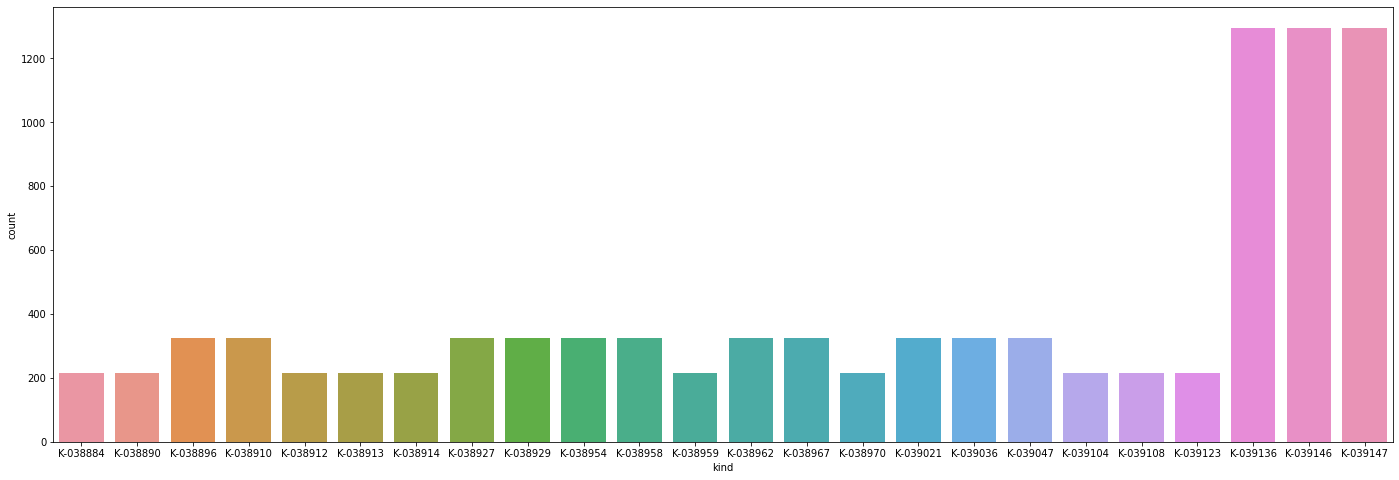

In [12]:
#kind
plt.figure(figsize=(24,8))
sns.countplot(df['kind'])
plt.show()

# 6. 이미지 확인

In [13]:
IMAGE_PATH = '/content/drive/MyDrive/SWBootcamp_Personal/images'

# image_kinds = 실제 이미지 파일 상단 폴더명 모음
image_kinds = list(os.listdir(IMAGE_PATH))
print(image_kinds) #24개
print('image_files len: ' + str(len(image_kinds)))

# image_files = 실제 이미지들 모음
image_files = list(os.listdir(IMAGE_PATH +'/'+ str(image_kinds[0])))
#print(image_files)
for i in range(1, len(image_kinds)):
  image_file_tmp = list(os.listdir(IMAGE_PATH +'/'+ str(image_kinds[i])))
  image_files = image_files + image_file_tmp
  print('image_files len: ' + str(len(image_files)))

#print(image_files)



print("Number of image files: {}".format(len(image_files)))

['K-038884', 'K-038912', 'K-038927', 'K-038954', 'K-038914', 'K-038910', 'K-038896', 'K-038890', 'K-038929', 'K-038913', 'K-038958', 'K-038970', 'K-039108', 'K-038959', 'K-038967', 'K-038962', 'K-039021', 'K-039104', 'K-039047', 'K-039036', 'K-039123', 'K-039136', 'K-039146', 'K-039147']
image_files len: 24
image_files len: 432
image_files len: 756
image_files len: 1080
image_files len: 1296
image_files len: 1620
image_files len: 1954
image_files len: 2170
image_files len: 2494
image_files len: 2710
image_files len: 3034
image_files len: 3250
image_files len: 3466
image_files len: 3682
image_files len: 4006
image_files len: 4330
image_files len: 4654
image_files len: 4870
image_files len: 5194
image_files len: 5518
image_files len: 5734
image_files len: 7040
image_files len: 8336
image_files len: 9632
Number of image files: 9632


In [14]:
file_names = list(df['Name']) #df의 'file' 칼럼 데이터로 리스트 생성 (파일명)

#file_names로 집합을 만들고, image file 이름과 매칭시킨 개수를 구한다.
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 9612


In [15]:
#이미지 그리는 함수
def draw_category_images(var,cols=5):
    categories = (df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[var]==cat].sample(cols)
        for j in range(0,cols):
            file = IMAGE_PATH + '/' + sample.iloc[j]['kind'] + '/' + sample.iloc[j]['Name']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

In [ ]:
draw_category_images('kind')  # 24종류 -> 24행 * 5열

Output hidden; open in https://colab.research.google.com to view.

# 7. train/test set 준비

In [112]:
#train set:test set = 0.8:0.2
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['kind'])
#print(type(train_df))

In [113]:
#확인
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))

Train set rows: 7689
Test  set rows: 1923


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


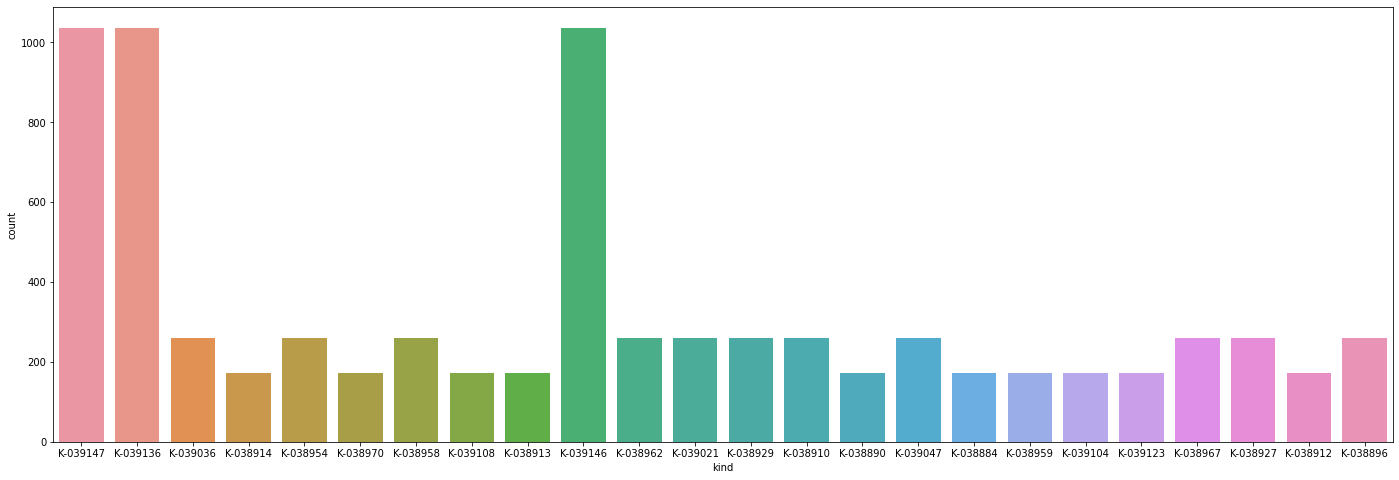

In [114]:
#train_df kind별
plt.figure(figsize=(24,8))
sns.countplot(train_df['kind'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


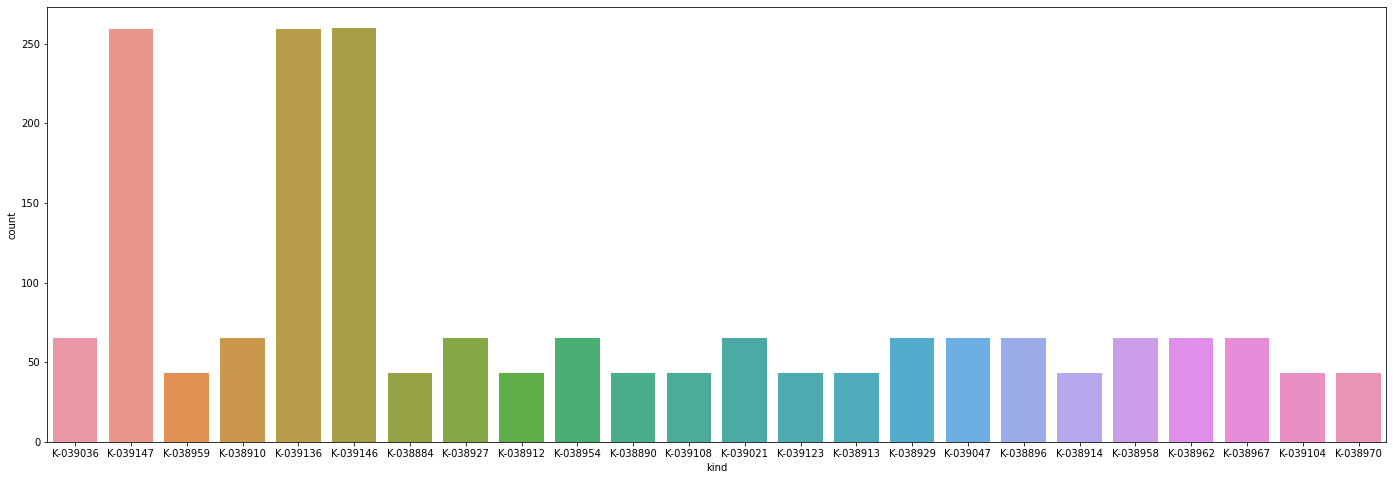

In [115]:
#test_df kind별
plt.figure(figsize=(24,8))
sns.countplot(test_df['kind'])
plt.show()

In [18]:
#이미지 경로에서 읽어오기 (size:50*50)   //원래는 200
def read_image(file_name):
  image = skimage.io.imread(IMAGE_PATH + '/' + file_name[0:8] + '/' + file_name)
  image = skimage.transform.resize(image, (50, 50), mode='reflect')
  return image[:,:,:3]

In [19]:
def categories_encoder(dataset, var):
    #file명을 읽어 이미지 경로에서 불러온다. X 값.
    X = np.stack(dataset['Name'].apply(read_image))
    # subspecies를 더미변수화 하여 y값으로
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

===========================================================================================================

In [20]:
#file명을 읽어 이미지 경로에서 불러온다. X 값.
X_train, y_train = categories_encoder(train_df, 'kind')

In [21]:
X_test, y_test = categories_encoder(test_df, 'kind')

In [116]:
#개수, size, channel
print(X_train.shape) # (trainset 개수, 크기,크기,rgb)
print(y_train.shape) # (trainset 개수, 몇 개의 subspecies)
print(X_test.shape) # (testset 개수, 크기,크기,rgb)
print(y_test.shape) # (testset 개수, 몇 개의 subspecies)
#print(type(X_test))

(7689, 50, 50, 3)
(7689, 24)
(1923, 50, 50, 3)
(1923, 24)


# 8. 모델링

In [155]:
#하이퍼 파라미터 생성
INPUT_SHAPE = (50, 50, 3) # 입력 데이터가 들어가는 포멧 설정  (원래는 50)
OUTPUT_SHAPE = 24 # 출력 데이터가 나오는 포멧 설정 (종류가 7개라서??) >>>>>>>>>>>> 24개로?
BATCH_SIZE = 128 # 한 번에 처리할 데이터량 설정
EPOCHS = 60 # 신경망을 학습할 횟수 (원래 15)
VERBOSE = 1 # 학습 진행 상황 출력 모드 설정 

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
  Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
  MaxPooling2D(pool_size=(2, 2)), 
  #필터 수: 32, 필터 사이즈: 3*3
  #input_shape: 입력 데이터 형태-> (행, 열, 채널수) = (200, 200, 3)  (50으로 변경함)
  #activation: 활성함수, relu=은닉층에 주로 사용

#flatten -> dense 128 (128개 뉴런) -> dens 64 -> dense 7 (7개의 데이터로 분류하여 출력) 으로 진행 >>>>>>>>>>>>>>>>>24개로?
  Flatten(),

  Dense(128, activation='relu'),
  Dropout(0.25),

  Dense(64, activation='relu'),
  Dropout(0.25),

  Dense(24, activation='softmax') # >>>>>>>>>>>>>>>>>>>>>24로?
])

In [157]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    #categorical_crossentropy: 다중 분류 손실함수. 출력값이 원 핫 인코딩 된 결과로 나온다.
    #각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
    metrics=['accuracy']
)

In [158]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               2359424   
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                      

# 9. 학습 및 결과

In [159]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience=3)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/60
49/49 [==============================] - 1s 14ms/step - loss: 2.7825 - accuracy: 0.1876 - val_loss: 2.0315 - val_accuracy: 0.3466
Epoch 2/60
49/49 [==============================] - 0s 9ms/step - loss: 1.7714 - accuracy: 0.4118 - val_loss: 1.1226 - val_accuracy: 0.6053
Epoch 3/60
49/49 [==============================] - 0s 9ms/step - loss: 1.2288 - accuracy: 0.5541 - val_loss: 0.6986 - val_accuracy: 0.7614
Epoch 4/60
49/49 [==============================] - 0s 9ms/step - loss: 0.9430 - accuracy: 0.6269 - val_loss: 0.5292 - val_accuracy: 0.7919
Epoch 5/60
49/49 [==============================] - 0s 9ms/step - loss: 0.7981 - accuracy: 0.6753 - val_loss: 0.4550 - val_accuracy: 0.7971
Epoch 6/60
49/49 [==============================] - 0s 9ms/step - loss: 0.7324 - accuracy: 0.6914 - val_loss: 0.3995 - val_accuracy: 0.8101
Epoch 7/60
49/49 [==============================] - 0s 9ms/step - loss: 0.6378 - accuracy: 0.7238 - val_loss: 0.3758 - val_accuracy: 0.8186
Epoch 8/60
49/49 [=

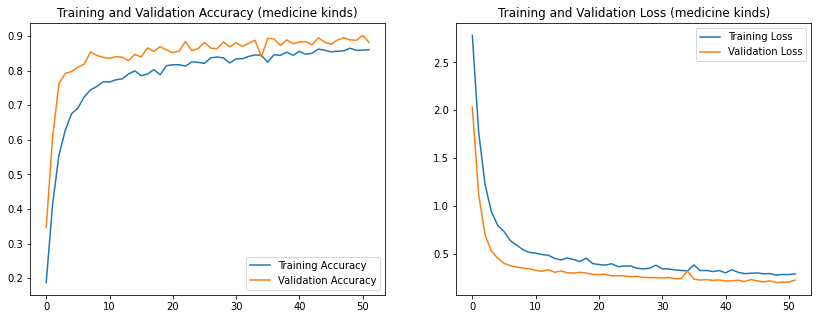

In [160]:
#결과 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (medicine kinds)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (medicine kinds)')

plt.show()

In [140]:
model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 3ms/step - loss: 0.2571 - accuracy: 0.8632


[0.25708553194999695, 0.8632345199584961]

In [45]:
#이미지 예측
#print(type(X_test))
predictions = model.predict(X_test)

<class 'numpy.ndarray'>
61/61 [==============================] - 0s 4ms/step


In [111]:
np.argmax(predictions[1922])

22

In [109]:
y_test

,K-038884,K-038890,K-038896,K-038910,K-038912,K-038913,K-038914,K-038927,K-038929,K-038954,...,K-038970,K-039021,K-039036,K-039047,K-039104,K-039108,K-039123,K-039136,K-039146,K-039147
4564,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
938,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# 10. 실제 이미지 넣어서 분류 (미완: 오류)
- 아마 50*50 사이즈에 rgb
- 하단 read_image 함수 이용해보기
  - def read_image(file_name):
    - image = skimage.io.imread(IMAGE_PATH + '/' + file_name[0:8] + '/' + file_name)
    - image = skimage.transform.resize(image, (50, 50), mode='reflect')
    - return image[:,:,:3]

In [74]:
# 테스트 이미지 경로에서 읽어오기 (size:50*50)   //원래는 200
def read_image_test(file_name):
  image = skimage.io.imread(file_name)
  image = skimage.transform.resize(image, (50, 50), mode='reflect')
  return image[:,:,:3]

In [75]:
def categories_encoder_test(file_name):
    #file명을 읽어 이미지 경로에서 불러온다. X 값.
    X = np.stack((read_image_test(file_name)))
    return X

In [ ]:
# 위 두 코드 합치기
test_img = categories_encoder_test('/content/drive/MyDrive/SWBootcamp_Personal/images/K-038884/K-038884_0_0_0_0_75_000_200.png')
#print(type(test_img)) #<class 'numpy.ndarray'>  >>  X_test와 동일한 데이터타입
model.predict(test_img)

test_img_prediction = model.predict(test_img)

# np.argmax(test_img_prediction)

In [ ]:
test = '/content/drive/MyDrive/SWBootcamp_Personal/images/K-038884/K-038884_0_0_0_0_75_000_200.png'

test_img = PIL.Image.open(test) # 파일 객체 불러오기
test_img = test_img.convert('RGB') # RGB 타입 변경
test_img = test_img.resize((50,50)) # 이미지 크기 변경
test_img = np.array(test_img)
test_img = test_img/255.0

print(type(test_img))

test_img_prediction = model.predict(test_img)
np.argmax(test_img_prediction)


print(test_img)


# + [Epochs 수에 따른 결과]

# Epochs 60
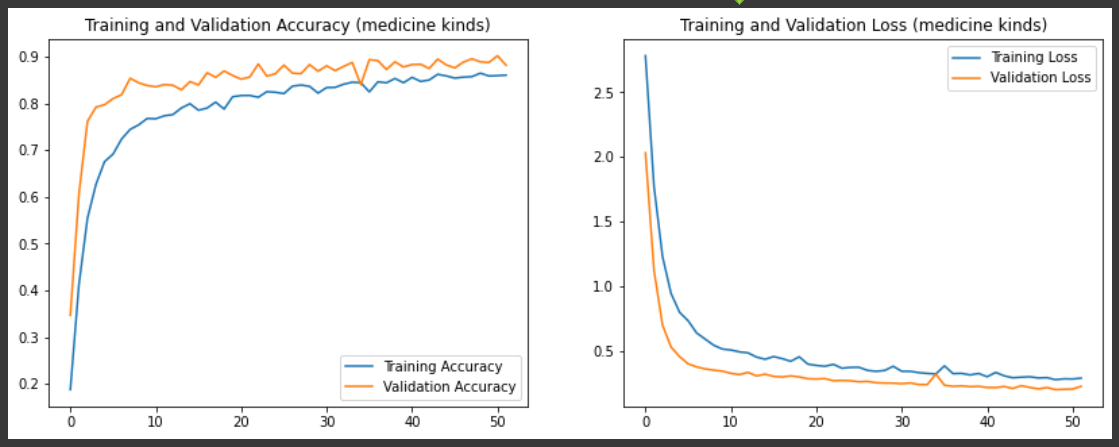

# epochs 30
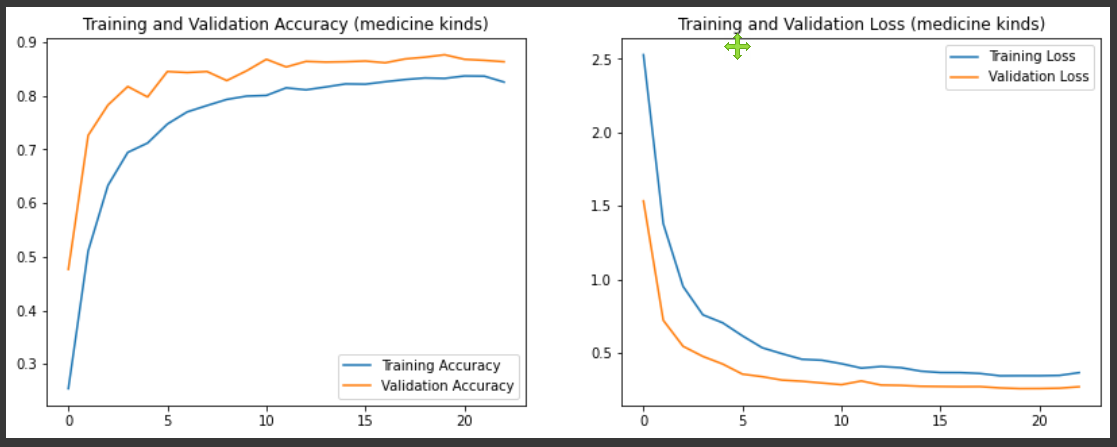

# epochs 15
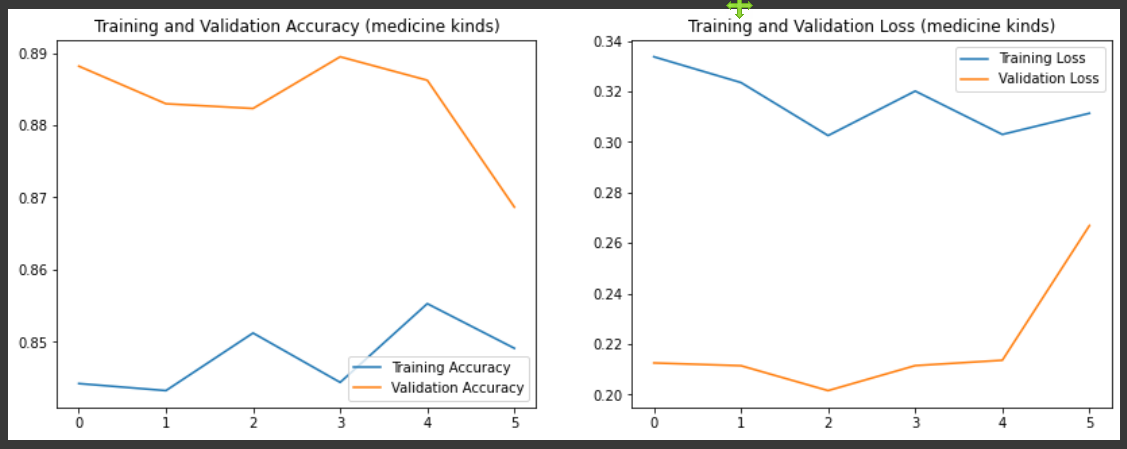

# epochs 10
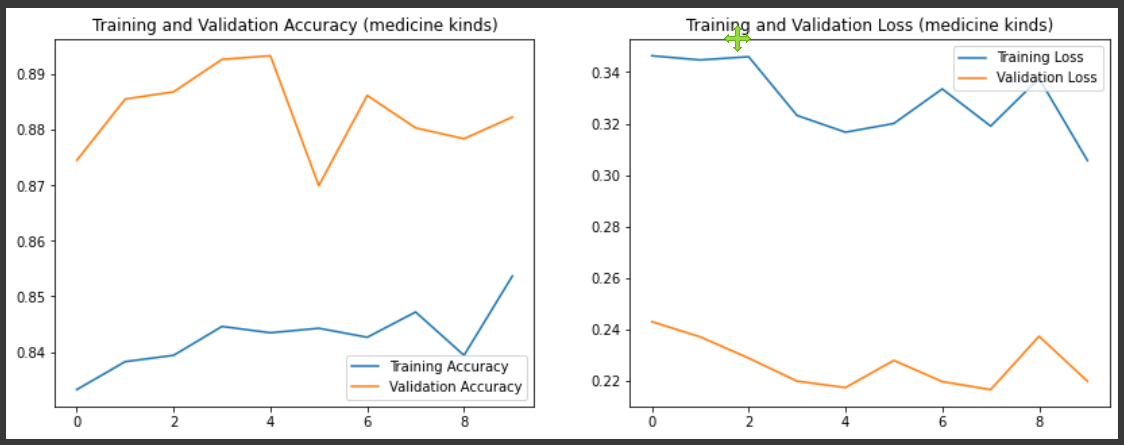